<a href="https://colab.research.google.com/github/young-hwanlee/my-practical-statistics-for-data-scientists/blob/main/Chapter_1_Exploratory_Data_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Practical Statistics for Data Scientists (Python)**
# **Chapter 1. Exploratory Data Analysis**
> (c) 2019 Peter C. Bruce, Andrew Bruce, and Peter Gedeck

Import required Python packeages.

In [1]:
%matplotlib inline

from pathlib import Path

import pandas as pd
import numpy as np
from scipy.stats import trim_mean
from statsmodels import robust

!pip install wquantiles
import wquantiles

import seaborn as sns
import matplotlib.pylab as plt

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
# try:
#     import common
#     DATA = common.dataDirectory()
# except ImportError:
#     DATA = Path().resolve() / 'data'

Define paths to data sets. If you don't keep your data in the same directory as the code, adapt the path names.

In [3]:
# AIRLINE_STATS_CSV = DATA / 'airline_stats.csv'
# KC_TAX_CSV = DATA / 'kc_tax.csv.gz'
# LC_LOANS_CSV = DATA / 'lc_loans.csv'
# AIRPORT_DELAYS_CSV = DATA / 'dfw_airline.csv'
# SP500_DATA_CSV = DATA / 'sp500_data.csv.gz'
# SP500_SECTORS_CSV = DATA / 'sp500_sectors.csv'
# STATE_CSV = DATA / 'state.csv'

DATA = 'https://raw.githubusercontent.com/young-hwanlee/practical-statistics-for-data-scientists/master/data/'

AIRLINE_STATS_CSV = DATA + 'airline_stats.csv'
KC_TAX_CSV = DATA + 'kc_tax.csv.gz'
LC_LOANS_CSV = DATA + 'lc_loans.csv'
AIRPORT_DELAYS_CSV = DATA + 'dfw_airline.csv'
SP500_DATA_CSV = DATA + 'sp500_data.csv.gz'
SP500_SECTORS_CSV = DATA + 'sp500_sectors.csv'
STATE_CSV = DATA + 'state.csv'

## **1.3 Estimates of Location**
### **Example: Location Estimates of Population and Murder Rates**

In [4]:
# Table 1-2
state = pd.read_csv(STATE_CSV)
print(state.head(8))

         State  Population  Murder.Rate Abbreviation
0      Alabama     4779736          5.7           AL
1       Alaska      710231          5.6           AK
2      Arizona     6392017          4.7           AZ
3     Arkansas     2915918          5.6           AR
4   California    37253956          4.4           CA
5     Colorado     5029196          2.8           CO
6  Connecticut     3574097          2.4           CT
7     Delaware      897934          5.8           DE


Compute the mean, trimmed mean, and median for Population. For mean and median, we can use the *pandas* methods of the data frame. The trimmed mean requires the trim_mean function in *scipy.stats*.

In [5]:
state = pd.read_csv(STATE_CSV)
print(state['Population'].mean())

6162876.3


In [6]:
print(trim_mean(state['Population'],0.1))

4783697.125


In [7]:
print(state['Population'].median())

4436369.5


Weighted mean is available with numpy. For weighted median, we can use the specialized package *wquantiles* (https://pypi.org/project/wquantiles/).

In [8]:
print(state['Murder.Rate'].mean())

4.066


In [9]:
print(np.average(state['Murder.Rate'],weights=state['Population']))

4.445833981123393


In [10]:
print(wquantiles.median(state['Murder.Rate'],weights=state['Population']))

4.4


## **1.4 Estimates of Variability**

In [11]:
# Table 1-2
print(state.head(8))

         State  Population  Murder.Rate Abbreviation
0      Alabama     4779736          5.7           AL
1       Alaska      710231          5.6           AK
2      Arizona     6392017          4.7           AZ
3     Arkansas     2915918          5.6           AR
4   California    37253956          4.4           CA
5     Colorado     5029196          2.8           CO
6  Connecticut     3574097          2.4           CT
7     Delaware      897934          5.8           DE


Standard deviation

In [12]:
print(state['Population'].std())

6848235.347401142


Interquartile range is calculated as the difference of the 75% and 25% quantile.

In [13]:
print(state['Population'].quantile(0.75) - state['Population'].quantile(0.25))

4847308.0


Median absolute deviation from the median (MAD) can be calculated with a method in *statsmodels* (robust.scale.mad).

In [14]:
print(robust.scale.mad(state['Population']))
print(abs(state['Population'] - state['Population'].median()).median() / 0.6744897501960817)

3849876.1459979336
3849876.1459979336


$$MAD \approx 0.67449 \sigma$$

In [15]:
print(robust.scale.mad(state['Population']) / state['Population'].std())

0.5621705374741444


https://onlinestatbook.com/2/introduction/percentiles.html

https://www.r-bloggers.com/2013/08/absolute-deviation-around-the-median/

### **1.5.1 Percentiles and Boxplots**

*Pandas* has the quantile method for data frames.

In [16]:
print(state['Murder.Rate'].quantile([0.05, 0.25, 0.5, 0.75, 0.95]))

0.05    1.600
0.25    2.425
0.50    4.000
0.75    5.550
0.95    6.510
Name: Murder.Rate, dtype: float64


In [17]:
# Table 1.4
percentages = [0.05, 0.25, 0.5, 0.75, 0.95]
df = pd.DataFrame(state['Murder.Rate'].quantile(percentages))
df.index = [f'{p*100}%' for p in percentages]
print(df.transpose())

             5.0%  25.0%  50.0%  75.0%  95.0%
Murder.Rate   1.6  2.425    4.0   5.55   6.51


*Pandas* provides a number of basic exploratory plots; one of them are boxplots.

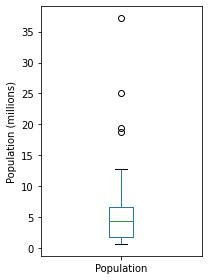

In [18]:
ax = (state['Population']/1_000_000).plot.box(figsize=(3, 4))
ax.set_ylabel('Population (millions)')

plt.tight_layout()
plt.show()

### **1.5.2 Frequency Table and Histograms**

The cut method for *pandas* data splits the dataset into bins. There are a number of arguments for the method. The following code creates equal sized bins. The method value_counts returns a frequency table.

In [19]:
binnedPopulation = pd.cut(state['Population'], 10)
print(binnedPopulation.value_counts())

(526935.67, 4232659.0]      24
(4232659.0, 7901692.0]      14
(7901692.0, 11570725.0]      6
(11570725.0, 15239758.0]     2
(33584923.0, 37253956.0]     1
(22577824.0, 26246857.0]     1
(18908791.0, 22577824.0]     1
(15239758.0, 18908791.0]     1
(29915890.0, 33584923.0]     0
(26246857.0, 29915890.0]     0
Name: Population, dtype: int64


In [20]:
# Table 1.5
binnedPopulation.name = 'binnedPopulation'
df = pd.concat([state, binnedPopulation], axis=1)
df = df.sort_values(by='Population')

groups = []
for group, subset in df.groupby(by='binnedPopulation'):
    groups.append({
        'BinRange': group,
        'Count': len(subset),
        'States': ','.join(subset.Abbreviation)
    })
print(pd.DataFrame(groups))

                   BinRange  ...                                             States
0    (526935.67, 4232659.0]  ...  WY,VT,ND,AK,SD,DE,MT,RI,NH,ME,HI,ID,NE,WV,NM,N...
1    (4232659.0, 7901692.0]  ...          KY,LA,SC,AL,CO,MN,WI,MD,MO,TN,AZ,IN,MA,WA
2   (7901692.0, 11570725.0]  ...                                  VA,NJ,NC,GA,MI,OH
3  (11570725.0, 15239758.0]  ...                                              PA,IL
4  (15239758.0, 18908791.0]  ...                                                 FL
5  (18908791.0, 22577824.0]  ...                                                 NY
6  (22577824.0, 26246857.0]  ...                                                 TX
7  (26246857.0, 29915890.0]  ...                                                   
8  (29915890.0, 33584923.0]  ...                                                   
9  (33584923.0, 37253956.0]  ...                                                 CA

[10 rows x 3 columns]


*Pandas* also supports histograms for exploratory data analysis.

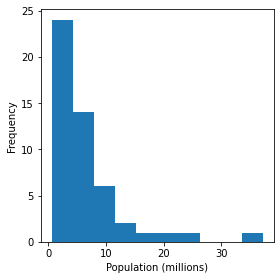

In [21]:
ax = (state['Population'] / 1_000_000).plot.hist(figsize=(4, 4))
ax.set_xlabel('Population (millions)')

plt.tight_layout()
plt.show()

### **1.5.3 Density Estimates**

Density is an alternative to histograms that can provide more insight into the distribution of the data points. Use the argument bw_method to control the smoothness of the density curve.

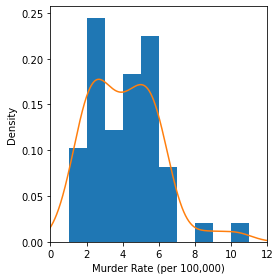

In [22]:
ax = state['Murder.Rate'].plot.hist(density=True, xlim=[0, 12],
                                    bins=range(1, 12), figsize=(4, 4))
state['Murder.Rate'].plot.density(ax=ax)
ax.set_xlabel('Murder Rate (per 100,000)')

plt.tight_layout()
plt.show()

## **1.6 Exploring Binary and Categorical Data**

In [23]:
# Table 1-6
dfw = pd.read_csv(AIRPORT_DELAYS_CSV)
print(100 * dfw / dfw.values.sum())

     Carrier        ATC   Weather  Security    Inbound
0  23.022989  30.400781  4.025214  0.122937  42.428079


*Pandas* also supports bar charts for displaying a single categorical variable.

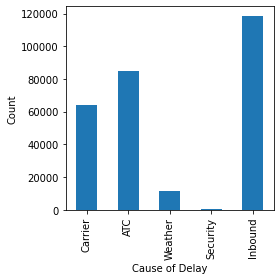

In [24]:
ax = dfw.transpose().plot.bar(figsize=(4, 4), legend=False)
ax.set_xlabel('Cause of Delay')
ax.set_ylabel('Count')

plt.tight_layout()
plt.show()

## **1.7 Correlation**

First read the required datasets.

In [25]:
sp500_sym = pd.read_csv(SP500_SECTORS_CSV)
sp500_px = pd.read_csv(SP500_DATA_CSV, index_col=0)

In [26]:
sp500_sym.head(5)

,sector,sector_label,sub_sector,symbol
0,information_technology,Technology,data_processing_&_outsourced_services,ADS
1,information_technology,Technology,systems_software,CA
2,information_technology,Technology,systems_software,MSFT
3,information_technology,Technology,systems_software,RHT
4,information_technology,Technology,it_consulting_&_services,CTSH


In [27]:
sp500_sym['sector'].unique()

array(['information_technology', 'industrials', 'energy',
       'consumer_discretionary', 'utilities', 'materials', 'etf',
       'telecommunications_services', 'consumer_staples', 'financials',
       'health_care'], dtype=object)

In [28]:
sp500_px.head(5)

,ADS,CA,MSFT,RHT,CTSH,CSC,EMC,IBM,XRX,ALTR,ADI,AVGO,BRCM,FSLR,INTC,LLTC,MCHP,MU,NVDA,QRVO,QCOM,SWKS,TXN,XLNX,AAPL,HPQ,EA,SNDK,STX,WDC,TEL,HRS,MSI,ACN,AMAT,KLAC,LRCX,ADBE,ADSK,ORCL,...,ENDP,LLY,MNK,MRK,MYL,PRGO,PFE,ZTS,ABT,A,BCR,BAX,BDX,BSX,EW,HSP,ISRG,JNJ,MDT,PKI,STJ,SYK,TMO,VAR,ZBH,BMY,CAH,CERN,ESRX,MCK,WAT,ALXN,AMGN,BXLT,BIIB,CELG,GILD,REGN,VRTX,HSIC
1993-01-29,0.0,0.060124,-0.022100,0.0,0.0,0.018897,0.007368,0.092165,0.259140,-0.007105,-0.015785,0.0,0.0,0.0,-0.050488,-0.089870,0.0,0.037021,0.0,0.0,-0.044718,-0.041262,0.060179,0.033152,-0.024235,0.045586,0.12500,0.0,0.0,0.118103,0.0,0.016412,-1.842719,0.0,-0.012867,0.079940,0.246706,-0.044884,0.057267,-0.005776,...,0.0,-0.077535,0.0,-0.028797,0.166355,-0.577943,0.066591,0.0,0.045961,0.0,-0.326659,0.000000,-0.033363,0.06250,0.0,0.0,0.0,0.018827,0.006047,0.000000,0.187132,0.276317,-0.124187,0.037430,0.0,0.038546,0.060142,0.03126,0.00195,0.0,0.0,0.0,0.34716,0.0,0.04167,0.00000,0.015564,1.75,0.1250,0.0
1993-02-01,0.0,-0.180389,0.027621,0.0,0.0,0.018889,0.018425,0.115207,-0.100775,0.063893,-0.015793,0.0,0.0,0.0,0.095367,0.044935,0.0,0.037020,0.0,0.0,0.006387,-0.041252,0.102317,0.099446,0.064618,0.072942,0.09375,0.0,0.0,0.000000,0.0,-0.032829,0.594428,0.0,0.016077,0.019985,0.411170,0.134672,0.057267,0.025999,...,0.0,-0.031014,0.0,-0.172781,-0.066536,0.346766,-0.027745,0.0,-0.045960,0.0,-0.093331,0.018157,0.100076,0.03125,0.0,0.0,0.0,-0.056481,-0.048392,0.041782,-0.074851,-0.027632,0.000000,-0.074859,0.0,-0.038546,0.060142,0.10156,0.01953,0.0,0.0,0.0,-0.23144,0.0,0.00000,-0.01041,0.007782,1.25,0.1250,0.0
1993-02-02,0.0,-0.120257,0.035900,0.0,0.0,-0.075573,0.029482,-0.023041,0.028796,-0.014192,0.047363,0.0,0.0,0.0,0.000000,0.067402,0.0,0.123402,0.0,0.0,0.035141,0.041252,-0.024066,0.016572,-0.016148,-0.045586,-0.06250,0.0,0.0,0.118103,0.0,-0.032829,0.237767,0.0,0.051450,0.000000,0.054828,0.082299,-0.042955,-0.011562,...,0.0,-0.062028,0.0,-0.143984,-0.066536,0.693532,-0.133183,0.0,-0.153198,0.0,-0.093331,-0.072626,0.000000,0.03125,0.0,0.0,0.0,-0.018827,0.000000,0.208912,0.018711,-0.027632,0.000000,0.044923,0.0,-0.115639,-0.030071,-0.01562,0.00000,0.0,0.0,0.0,-0.11572,0.0,0.00000,0.00000,-0.007792,-0.25,0.0000,0.0
1993-02-03,0.0,0.060124,-0.024857,0.0,0.0,-0.151128,0.003689,-0.253454,-0.043190,-0.007105,0.205236,0.0,0.0,0.0,-0.050495,0.022467,0.0,-0.012340,0.0,0.0,0.006387,0.041252,-0.024073,0.049723,-0.032305,-0.091184,0.21875,0.0,0.0,0.059052,0.0,0.049247,-0.118893,0.0,0.000000,0.039970,-0.054828,-0.149639,0.057267,0.002884,...,0.0,0.139564,0.0,0.345561,0.133081,0.693532,0.022199,0.0,0.168520,0.0,0.093331,0.090783,0.044480,0.03125,0.0,0.0,0.0,0.263578,0.030243,0.125347,0.187140,0.000000,0.124187,0.104805,0.0,0.141333,0.000000,-0.01172,0.02344,0.0,0.0,0.0,-0.08679,0.0,0.04167,-0.04167,-0.038919,-0.50,0.0625,0.0
1993-02-04,0.0,-0.360770,-0.060757,0.0,0.0,0.113350,-0.022114,0.069862,0.000000,-0.007096,-0.031570,0.0,0.0,0.0,0.000000,0.022467,0.0,-0.074041,0.0,0.0,0.051113,0.041252,-0.024073,-0.008290,-0.016157,-0.109414,0.09375,0.0,0.0,-0.118103,0.0,0.000000,-0.237776,0.0,-0.003219,-0.099925,-0.246706,0.000000,-0.157480,-0.017329,...,0.0,0.000000,0.0,-0.345561,-0.133073,-0.924709,-0.016648,0.0,-0.061282,0.0,0.186662,0.000000,-0.011123,-0.15625,0.0,0.0,0.0,0.018827,-0.024196,0.167129,-0.187629,-0.082895,0.341510,-0.029946,0.0,-0.115635,0.060142,-0.00782,-0.01562,0.0,0.0,0.0,0.14465,0.0,-0.04166,-0.03126,-0.046711,0.00,0.0625,0.0


In [29]:
sp500_px.index

Index(['1993-01-29', '1993-02-01', '1993-02-02', '1993-02-03', '1993-02-04',
       '1993-02-05', '1993-02-08', '1993-02-09', '1993-02-10', '1993-02-11',
       ...
       '2015-06-18', '2015-06-19', '2015-06-22', '2015-06-23', '2015-06-24',
       '2015-06-25', '2015-06-26', '2015-06-29', '2015-06-30', '2015-07-01'],
      dtype='object', length=5647)

In [30]:
# Table 1-7
# Determine telecommunications symbols
telecomSymbols = sp500_sym[sp500_sym['sector'] == 'telecommunications_services']['symbol']

# Filter data for dates July 2012 through June 2015
telecom = sp500_px.loc[sp500_px.index >= '2012-07-01', telecomSymbols]
telecom.corr()
print(telecom)

                   T       CTL       FTR        VZ      LVLT
2012-07-02  0.422496  0.140847  0.070879  0.554180 -0.519998
2012-07-03 -0.177448  0.066280  0.070879 -0.025976 -0.049999
2012-07-05 -0.160548 -0.132563  0.055128 -0.051956 -0.180000
2012-07-06  0.342205  0.132563  0.007875  0.140106 -0.359999
2012-07-09  0.136883  0.124279 -0.023626  0.253943  0.180000
...              ...       ...       ...       ...       ...
2015-06-25  0.049342 -1.600000 -0.040000 -0.187790 -0.330002
2015-06-26 -0.256586  0.039999 -0.070000  0.029650 -0.739998
2015-06-29 -0.098685 -0.559999 -0.060000 -0.504063 -1.360000
2015-06-30 -0.503298 -0.420000 -0.070000 -0.523829  0.199997
2015-07-01 -0.019737  0.080000 -0.050000  0.355811  0.139999

[754 rows x 5 columns]


Next we focus on funds traded on major exchanges (sector == 'etf').

In [31]:
etfs = sp500_px.loc[sp500_px.index > '2012-07-01',
                    sp500_sym[sp500_sym['sector'] == 'etf']['symbol']]
print(etfs.head())

                 XLI       QQQ       SPY  ...       XLP       XLF       XLK
2012-07-02 -0.376098  0.096313  0.028223  ...  0.313499  0.018999  0.075668
2012-07-03  0.376099  0.481576  0.874936  ...  0.129087  0.104492  0.236462
2012-07-05  0.150440  0.096313 -0.103487  ... -0.073766 -0.142490  0.066211
2012-07-06 -0.141040 -0.491201  0.018819  ...  0.119865  0.066495 -0.227003
2012-07-09  0.244465 -0.048160 -0.056445  ... -0.064548  0.018999  0.009457

[5 rows x 17 columns]


Due to the large number of columns in this table, looking at the correlation matrix is cumbersome and it's more convenient to plot the correlation as a heatmap. The *seaborn* package provides a convenient implementation for heatmaps.

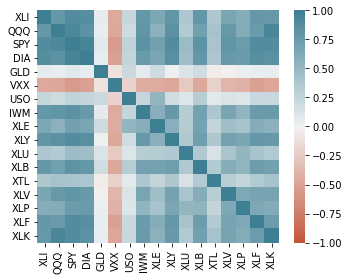

In [32]:
fig, ax = plt.subplots(figsize=(5, 4))
ax = sns.heatmap(etfs.corr(), vmin=-1, vmax=1,
                 cmap=sns.diverging_palette(20, 220, as_cmap=True),
                 ax=ax)

plt.tight_layout()
plt.show()

The above heatmap works when you have color. For the greyscale images, as used in the book, we need to visualize the direction as well. The following code shows the strength of the correlation using ellipses.

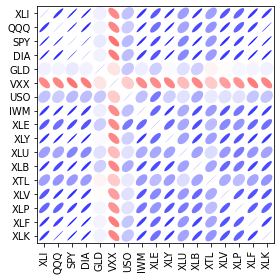

In [33]:
from matplotlib.collections import EllipseCollection
from matplotlib.colors import Normalize

def plot_corr_ellipses(data, figsize=None, **kwargs):
    ''' https://stackoverflow.com/a/34558488 '''
    M = np.array(data)
    if not M.ndim == 2:
        raise ValueError('data must be a 2D array')
    fig, ax = plt.subplots(1, 1, figsize=figsize, subplot_kw={'aspect':'equal'})
    ax.set_xlim(-0.5, M.shape[1] - 0.5)
    ax.set_ylim(-0.5, M.shape[0] - 0.5)
    ax.invert_yaxis()

    # xy locations of each ellipse center
    xy = np.indices(M.shape)[::-1].reshape(2, -1).T

    # set the relative sizes of the major/minor axes according to the strength of
    # the positive/negative correlation
    w = np.ones_like(M).ravel() + 0.01
    h = 1 - np.abs(M).ravel() - 0.01
    a = 45 * np.sign(M).ravel()

    ec = EllipseCollection(widths=w, heights=h, angles=a, units='x', offsets=xy,
                           norm=Normalize(vmin=-1, vmax=1),
                           transOffset=ax.transData, array=M.ravel(), **kwargs)
    ax.add_collection(ec)

    # if data is a DataFrame, use the row/column names as tick labels
    if isinstance(data, pd.DataFrame):
        ax.set_xticks(np.arange(M.shape[1]))
        ax.set_xticklabels(data.columns, rotation=90)
        ax.set_yticks(np.arange(M.shape[0]))
        ax.set_yticklabels(data.index)

    return ec

m = plot_corr_ellipses(etfs.corr(), figsize=(5, 4), cmap='bwr_r')
cb = fig.colorbar(m)
cb.set_label('Correlation coefficient')

plt.tight_layout()
plt.show()

### **1.7.1 Scatterplots**

Simple scatterplots are supported by *pandas*. Specifying the marker as $\u25EF$ uses an open circle for each point.

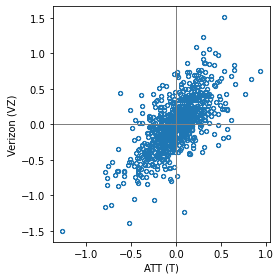

In [34]:
ax = telecom.plot.scatter(x='T', y='VZ', figsize=(4, 4), marker='$\u25EF$')
ax.set_xlabel('ATT (T)')
ax.set_ylabel('Verizon (VZ)')
ax.axhline(0, color='grey', lw=1)
ax.axvline(0, color='grey', lw=1)

plt.tight_layout()
plt.show()

Line2D(_line1)


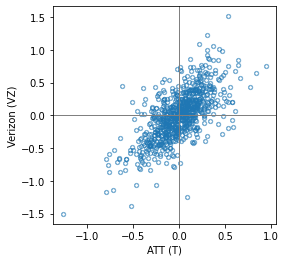

In [35]:
ax = telecom.plot.scatter(x='T', y='VZ', figsize=(4, 4), marker='$\u25EF$', alpha=0.5)
ax.set_xlabel('ATT (T)')
ax.set_ylabel('Verizon (VZ)')
ax.axhline(0, color='grey', lw=1)
print(ax.axvline(0, color='grey', lw=1))

## **1.8 Exploring Two or More Variables**

Load the kc_tax dataset and filter based on a variety of criteria.

In [36]:
kc_tax = pd.read_csv(KC_TAX_CSV)
kc_tax.head(5)

,TaxAssessedValue,SqFtTotLiving,ZipCode
0,NaN,1730,98117.0
1,206000.0,1870,98002.0
2,303000.0,1530,98166.0
3,361000.0,2000,98108.0
4,459000.0,3150,98108.0


In [37]:
print(kc_tax.shape)

(498249, 3)


In [38]:
kc_tax0 = kc_tax.loc[(kc_tax.TaxAssessedValue < 750000) &
                     (kc_tax.SqFtTotLiving > 100) &
                     (kc_tax.SqFtTotLiving < 3500), :]
print(kc_tax0.shape)

(432693, 3)


### **1.8.1 Hexagonal binning and Contours**
#### **Plotting numeric data versus numeric data**

If the number of data points gets large, scatter plots will no longer be meaningful. Here methods that visualize densities are more useful. The hexbin method for *pandas* data frames is one powerful approach.

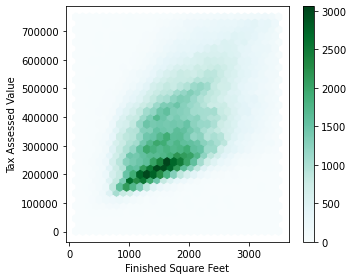

In [39]:
ax = kc_tax0.plot.hexbin(x='SqFtTotLiving', y='TaxAssessedValue',
                         gridsize=30, sharex=False, figsize=(5, 4))
ax.set_xlabel('Finished Square Feet')
ax.set_ylabel('Tax Assessed Value')

plt.tight_layout()
plt.show()

The *seaborn* kdeplot is a two-dimensional extension of the density plot. The calculation of the 2D-density for the full dataset takes several minutes. It is sufficient to create the visualization with a smaller sample of the dataset. With 10,000 data points, creating the graph takes only seconds. While some details may be lost, the overall shape is preserved.

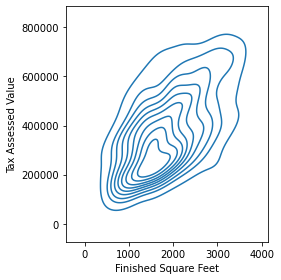

In [40]:
fig, ax = plt.subplots(figsize=(4, 4))
sns.kdeplot(data=kc_tax0.sample(1000), x='SqFtTotLiving', y='TaxAssessedValue', ax=ax)
ax.set_xlabel('Finished Square Feet')
ax.set_ylabel('Tax Assessed Value')

plt.tight_layout()
plt.show()

### **1.8.2 Two Categorical Variables**

Load the lc_loans dataset.

In [41]:
lc_loans = pd.read_csv(LC_LOANS_CSV)
lc_loans.head(5)

,status,grade
0,Fully Paid,B
1,Charged Off,C
2,Fully Paid,C
3,Fully Paid,C
4,Current,B


In [42]:
print(lc_loans.shape)

(450961, 2)


In [43]:
# Table 1-8(1)
crosstab = lc_loans.pivot_table(index='grade', columns='status',
                                aggfunc=lambda x: len(x), margins=True)
print(crosstab)
crosstab

status  Charged Off  Current  Fully Paid  Late     All
grade                                                 
A              1562    50051       20408   469   72490
B              5302    93852       31160  2056  132370
C              6023    88928       23147  2777  120875
D              5007    53281       13681  2308   74277
E              2842    24639        5949  1374   34804
F              1526     8444        2328   606   12904
G               409     1990         643   199    3241
All           22671   321185       97316  9789  450961


status,Charged Off,Current,Fully Paid,Late,All
grade,,,,,
A,1562,50051,20408,469,72490
B,5302,93852,31160,2056,132370
C,6023,88928,23147,2777,120875
D,5007,53281,13681,2308,74277
E,2842,24639,5949,1374,34804
F,1526,8444,2328,606,12904
G,409,1990,643,199,3241
All,22671,321185,97316,9789,450961


In [44]:
# Table 1-8(2)
df = crosstab.copy().loc['A':'G', :]
df.loc[:, 'Charged Off':'Late'] = df.loc[:, 'Charged Off':'Late'].div(df['All'], axis=0)
df['All']

grade
A     72490
B    132370
C    120875
D     74277
E     34804
F     12904
G      3241
Name: All, dtype: int64

In [45]:
df

status,Charged Off,Current,Fully Paid,Late,All
grade,,,,,
A,0.021548,0.690454,0.281528,0.006470,72490
B,0.040054,0.709013,0.235401,0.015532,132370
C,0.049828,0.735702,0.191495,0.022974,120875
D,0.067410,0.717328,0.184189,0.031073,74277
E,0.081657,0.707936,0.170929,0.039478,34804
F,0.118258,0.654371,0.180409,0.046962,12904
G,0.126196,0.614008,0.198396,0.061401,3241


In [46]:
df['All'] = df['All'] / sum(df['All'])
perc_crosstab = df
print(perc_crosstab)
perc_crosstab

status  Charged Off   Current  Fully Paid      Late       All
grade                                                        
A          0.021548  0.690454    0.281528  0.006470  0.160746
B          0.040054  0.709013    0.235401  0.015532  0.293529
C          0.049828  0.735702    0.191495  0.022974  0.268039
D          0.067410  0.717328    0.184189  0.031073  0.164708
E          0.081657  0.707936    0.170929  0.039478  0.077177
F          0.118258  0.654371    0.180409  0.046962  0.028614
G          0.126196  0.614008    0.198396  0.061401  0.007187


status,Charged Off,Current,Fully Paid,Late,All
grade,,,,,
A,0.021548,0.690454,0.281528,0.006470,0.160746
B,0.040054,0.709013,0.235401,0.015532,0.293529
C,0.049828,0.735702,0.191495,0.022974,0.268039
D,0.067410,0.717328,0.184189,0.031073,0.164708
E,0.081657,0.707936,0.170929,0.039478,0.077177
F,0.118258,0.654371,0.180409,0.046962,0.028614
G,0.126196,0.614008,0.198396,0.061401,0.007187


### **1.8.3 Categorical and Numeric Data**

*Pandas* boxplots of a column can be grouped by a different column.

In [47]:
airline_stats = pd.read_csv(AIRLINE_STATS_CSV)
airline_stats.head()

,pct_carrier_delay,pct_atc_delay,pct_weather_delay,airline
0,8.153226,1.971774,0.762097,American
1,5.959924,3.706107,1.585878,American
2,7.157270,2.706231,2.026706,American
3,12.100000,11.033333,0.000000,American
4,7.333333,3.365591,1.774194,American


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


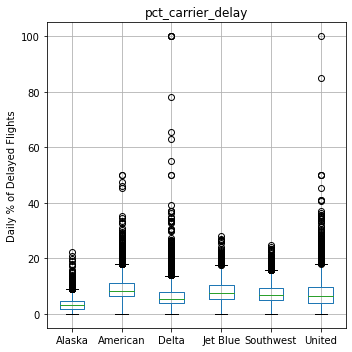

In [48]:
ax = airline_stats.boxplot(by='airline', column='pct_carrier_delay',
                           figsize=(5, 5))
ax.set_xlabel('')
ax.set_ylabel('Daily % of Delayed Flights')
plt.suptitle('')

plt.tight_layout()
plt.show()

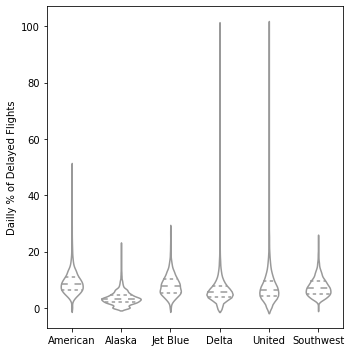

In [49]:
fig, ax = plt.subplots(figsize=(5, 5))
sns.violinplot(data=airline_stats, x='airline', y='pct_carrier_delay',
               ax=ax, inner='quartile', color='white')
ax.set_xlabel('')
ax.set_ylabel('Dailly % of Delayed Flights')

plt.tight_layout()
plt.show()

### **1.8.4 Visualizing Multiple Variables**

In [50]:
zip_codes = [98188, 98105, 98108, 98126]
kc_tax_zip = kc_tax0.loc[kc_tax0.ZipCode.isin(zip_codes),:]
kc_tax_zip

,TaxAssessedValue,SqFtTotLiving,ZipCode
3,361000.0,2000,98108.0
4,459000.0,3150,98108.0
10,202000.0,830,98108.0
11,210000.0,1130,98108.0
12,193000.0,1560,98108.0
...,...,...,...
498049,346000.0,1430,98105.0
498050,463000.0,1610,98105.0
498051,553000.0,1580,98105.0
498052,571000.0,1840,98105.0


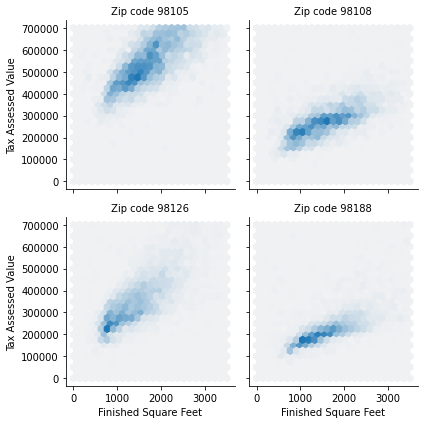

In [51]:
def hexbin(x, y, color, **kwargs):
    cmap = sns.light_palette(color, as_cmap=True)
    plt.hexbin(x, y, gridsize=25, cmap=cmap, **kwargs)

g = sns.FacetGrid(kc_tax_zip, col='ZipCode', col_wrap=2)
g.map(hexbin, 'SqFtTotLiving', 'TaxAssessedValue', 
      extent=[0, 3500, 0, 700000])
g.set_axis_labels('Finished Square Feet', 'Tax Assessed Value')
g.set_titles('Zip code {col_name:.0f}')

plt.tight_layout()
plt.show()